In [1]:
import torch
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import random
from IPython.display import clear_output
from multiprocessing.pool import ThreadPool

In [2]:
class ActorNet(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(ActorNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,256)
        self.elu1 = nn.Tanh()
#         self.fc2 = nn.Linear(512,256)
#         self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(256,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,output_dim)
        self.value = nn.Linear(64,1)
        
    def forward(self,obj,action=False,max_act=False,value=False):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
#         x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        logits = self.fc4(x)
        v = self.value(x)
        m = Categorical(logits=logits)
        act = m.sample()
        log_p = m.log_prob(act)
        if action:
            return m.log_prob(torch.LongTensor(action))
        elif value:
            return v
        else:
            if max_act:
                return torch.argmax(logits).item()
            else:
                return m,act.item(),log_p,v
            

In [3]:
make = 'Pong-ram-v0'

In [4]:
env = gym.make(make)

In [5]:
input_dim = env.observation_space.shape[0]

In [6]:
output_dim = env.action_space.n

In [7]:
act_net = ActorNet(input_dim,output_dim)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr_pi = 1e-4
lr_v = 1e-3
target_kl = 0.01
train_pi_iter = 5
train_v_iter = 5
traj_n = 10
iters = 200
batch_size = 32

In [ ]:
optim_actor = optim.Adam(params=act_net.parameters(),lr=lr_pi)

In [ ]:
def disc_cuml_rew_calc(rews,gamma=gamma):
    return list(scipy.signal.lfilter([1], [1, float(-gamma)], rews[::-1], axis=0)[::-1])

In [ ]:
def traject(t):
    traj = []
    rews = []
    env = gym.make(make)
    obj = env.reset()
    done = False
    while not done:
        m,act,log_p,v = act_net.forward(obj)
        next_obj,reward,done,_ = env.step(act)
        reward += m.entropy().item() * 0.1
        traj.append([act,obj,next_obj,reward,done,log_p,v])
        rews.append(reward)
        obj = next_obj
    rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
    act,obj,_,rews,_,old_policy,v = zip(*traj)
    adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
    adv = torch.FloatTensor(adv)
    adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
    adv = torch.FloatTensor(adv)
    adv = (adv - adv.mean())/adv.std()
    traj = [i + [j,k] for i,j,k in zip(traj,rews_disc_cuml_scaled,adv)]
    return traj,rews

In [ ]:
def break_list(sublst_ln,lst):
    """
    Divides given list into sublists of given length
    """
    all_parts = len(lst)//sublst_ln
    last_part = len(lst)%sublst_ln
    tmp = []
    for i in range(all_parts):
        tmp.append(lst[i*sublst_ln:(i+1)*sublst_ln])
    if last_part > 0:
        tmp.append(lst[sublst_ln*all_parts:])
    return tmp

10


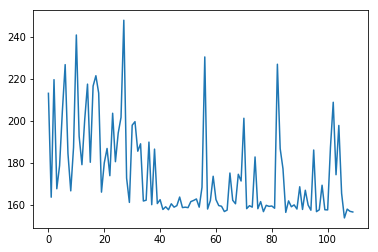

11
12
13
14


In [ ]:
rewards = []
for k in range(iters):
    print(k)
    process = ThreadPool(processes=8)
    out = process.map(traject,range(traj_n))
    process.close()
    process.join()
    broken_out = break_list(batch_size,out)
    for b in broken_out:
        trajectories,rewards_t = list(zip(*b))
        rewards.extend(rewards_t)
        trajectories = reduce(lambda a,b: a+b,trajectories)
        act,obj,_,rews,_,old_policy,v,rews_disc_cuml,adv = zip(*trajectories)
        adv = torch.FloatTensor(adv)
        old_policy = torch.FloatTensor(old_policy)
        old_policy = old_policy
        for t in range(train_pi_iter):
            new_policy = act_net.forward(obj,action=act)
            ratio = torch.exp(new_policy-old_policy)
            clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
            loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
            loss_v = ((act_net.forward(obj,value=True) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
            loss = loss_pi + loss_v
            optim_actor.zero_grad()
            loss.backward()
            optim_actor.step()
            if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
                print('early_stopping')
                break

        if k % 10 == 0:
            clear_output(wait=True)
            print(k)
            episode_returns = [sum(i) for i in rewards]
            plt.plot(episode_returns)
            plt.show()

In [90]:
episode_returns = [sum(i) for i in rewards]

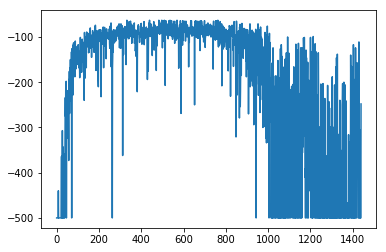

In [91]:
plt.plot(episode_returns)

In [92]:
import time

In [98]:
done = False
obj = env.reset()
rw = 0
while not done:
# for r in range(800):
#     print('**********************************')
    m,act,log_p = act_net.forward(obj)
#     time.sleep(0.02)
#     print(m.logits)
#     print(m.logits.argmax())
#     print(act)
    obj,reward,done,_ = env.step(act)
    rw += reward
    env.render()
env.close()
print(rw)

-500.0


In [59]:
env.close()

In [40]:
act

0

In [43]:
m.logits

tensor([-1.6989, -1.7558, -2.4567, -0.5823], grad_fn=<SubBackward0>)

In [28]:
k = torch.load('ppo_multitraj_cartpole')

In [120]:
# torch.save(act_net,'ppo_multitraj_acrobat')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
